# Resizer in Programmable Logic (PL)

This reference design illustrates how to run a resizer IP on the **Programmable Logic (PL)** using Jupyter Notebooks and Python.

<img src="./images/resizenb.png" width="800" height="650"/>

In this example, we will use the **Bilinear** interpolation.

> The resize IP transforms the source image to the size of the destination image. Different types of interpolation techniques can be used in resize function,
namely: Nearest-neighbor, Bilinear, and Area interpolation. The type of interpolation can be passed as a parameter to the Python API.    
> Reference: https://xilinx.github.io/Vitis_Libraries/vision/2021.1/api-reference.html#resolution-conversion

## Contents    
  

* [Image Resizing in Programmable Logic](#Image-Resizing-in-Programmable-Logic)
* [Import libraries](#Import-libraries)
* [Download the Resize IP bitstream](#Download-the-Resize-IP-bitstream)
* [Create an Image object using PIL in SW](#Create-an-Image-object-using-PIL-in-SW)
* [Display the image to be resized](#Display-the-image-to-be-resized)
* [Resizing](#Resizing)
* [Display resized image](#Display-resized-image)
* [References](#References)   

## Image Resizing in Programmable Logic


<img src="./images/resize_bd.png" width="800" height="650"/>

## Import libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay 

## Download the Resize IP bitstream

After the bitstream has been downloaded, the PL will be populated with
the resize IP, the DMA engine, and a few other components. The resize IP
is configured to use bilinear interpolation.

In [2]:
resize_design = Overlay("resizer.bit")

Then create DMA and Resizer IP objects.

In [3]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0


<img src="./images/resize_bit.png" width="600" height="450"/>


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

Image By Aboubakrhadnine - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=79587474">Link</a>.

In [4]:
image_path = "images/sahara.jpg"
original_image = Image.open(image_path)

<img src="images/sd2dram.png" width="650" height="550"/>

## Display the image to be resized

Let's also check the original image size. It may take a while to render a 
large picture. For better visual effect, we double the size of the canvas.
The following code only changes the display size, not the picture itself:

```python
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
```

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

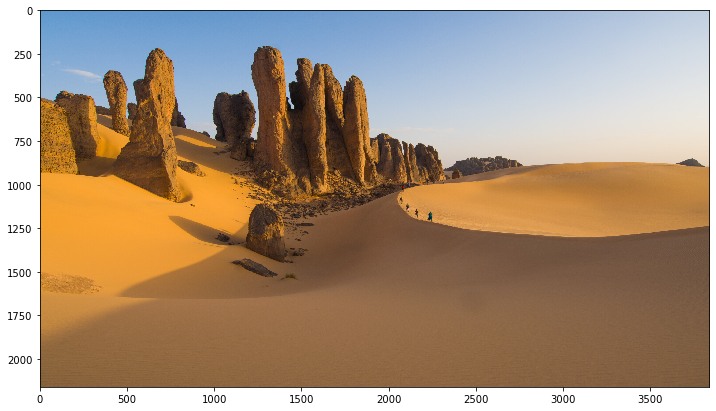

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

## Resizing
 
We can set resize dimensions.
1. Downscale factor: 2.
2. Size of input image is 3840x2160.
3. Size of output image is 1920x1080.

In [6]:
resize_factor = 2
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `allocate()` to perform the allocation.

In [7]:
in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

Documentation snippet for `allocate`:

```python
"""Allocate a PYNQ buffer

This API mimics the numpy ndarray constructor with the following
differences:

 * The default dtype is 32-bit unsigned int rather than float
 * A new ``target`` keyword parameter to determine where the
   buffer should be allocated

The target determines where the buffer gets allocated

 * If None then the currently active device is used
 * If a Device is specified then the main memory

"""
```

Note that the original image has to be copied into the contiguous memory array (deep copy).

<img src="./images/local2shared.png" width="650" height="550"/>

In [8]:
in_buffer[:] = np.array(original_image)

We can now run the resizer IP.
We will push the data from input buffer through the pipeline to the output buffer.
For ease-of-use, we will define a `run_kernel` function that will be called 
multiple times.

<img src="./images/resize_accel.png" width="650" height="550"/>

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

We will also need to setup resizer and DMA IPs using MMIO interface 
before we stream image data to them.
For example, we need to write dimensions data to MMIO registers of resizer.
These register writings only have to be done once.

| register offset | name     | configuration                          |
|-----------------|----------|----------------------------------------|
| 0x10            | src_rows | number of rows of original picture    |
| 0x18            | src_cols | number of columns of original picture |
| 0x20            | dst_rows | number of rows of resized picture     |
| 0x28            | dst_cols | number of columns of resized picture  |

PYNQ populates these names from the IP directly into the register map `resizer.register_map`

In [10]:
resizer.register_map.src_rows = old_height
resizer.register_map.src_cols = old_width
resizer.register_map.dst_rows = new_height
resizer.register_map.dst_cols = new_width

Now we can perform the resizing operation.

In [11]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## Display resized image

Image size: 1920x1080 pixels.


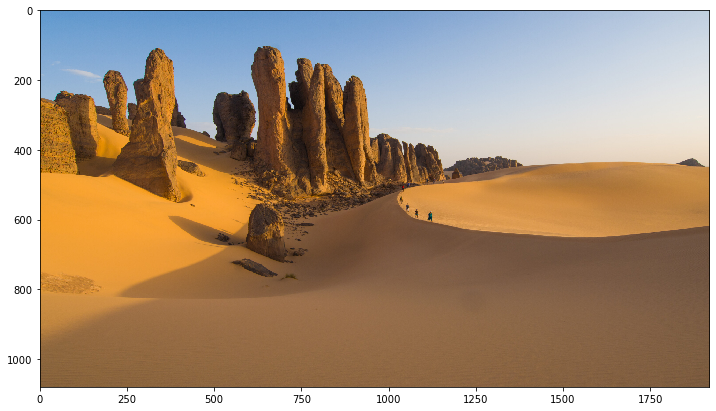

In [12]:
print("Image size: {}x{} pixels.".format(new_width, new_height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(resized_image)

We can time the resize in PL operation.

In [13]:
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

251 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally we need to free all the contiguous memory buffers.

In [14]:
del in_buffer
del out_buffer

[Contents](#Contents)

# References

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   